In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [28]:
location_ids = [163,214,179]

ages = [1,2,3,4,5] # [49,50,51,52]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [4]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [5]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [6]:
def lognormal_draws(mu, sigma, seed):
    """
    INPUT:
    - mean of distirbution
    - std dev of distribution
    - random seed
    -----
    @returns: 1000 draws from a lognormal distribution with requested params
    """
    np.random.seed(seed)
    return np.random.lognormal(mu, sigma, size=1000)

In [7]:
def format_rrs(rrs, location_ids):
    """
    INPUT:
    - an array of 1000 rrs, representing the rr distribution
    - a list of location_ids
    -----
    @ returns: a DataFrame
        - long by loc_id (as index)
        - wide by draws
        - same rr for each draw for each loc_id
    """
    draws = [f'draw_{i}' for i in range(1_000)]
    
    df = pd.DataFrame([rrs for i in location_ids], index = location_ids, columns = draws)
    df.index.name = 'location_id'
    
    return df

In [8]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
163    1.712028
214    1.712028
179    1.712028
dtype: float64

In [50]:
nutrient, vehicle, coverage_levels, years, location_ids, sub_pop = nutrient, vehicle, alternative_scenario_coverage_levels, [2021,2022,2023,2024,2025], location_ids, "wra"

In [89]:
def pull_coverage_data(vivarium_data_analysis_path, nutrient, vehicle, sub_pop):
    """
    Load pct of fortified and fortifiable data for a given vehicle/nutrient/loc_id set
    ----
    INPUTS:
    - filepath to the vivarium_data_analysis repo. eg, '/ihme/homes/beatrixh/vivarium_data_analysis'
    - nutrient of interest
    - vehicle of interest
    - sup_pop of interest, either 'wra' or 'u5'
    ----
    OUTPUT:
    a pd.DataFrame() with:
    - location_id, location_name, sub_populuation, value_descrip, nutrient, value_mean, value_025_percentile, value_975_percentile
    """
    coverage_data_path = vivarium_data_analysis_path + '/pre_processing/lsff_project/data_prep/outputs/nigeria_ethiopia_india_coverage_data.csv'
    data = pd.read_csv(coverage_data_path)
    #TODO: fix this to deal more cleanly with all possible cases!
    if sub_pop=='u5':
        data = data.loc[data.location_id.isin(location_ids)].loc[data.sub_population!='women of reproductive age']
    elif sub_pop=='wra':
        data = data.loc[data.location_id.isin(location_ids)].loc[data.sub_population!='under-5']
    else:
        raise Exception("Subpop must be either 'wra' or 'u5'")
        
    #TODO: ADD A CHECK FOR UNIQUENESS OF ROWS
    
    return data.loc[(data.vehicle == vehicle) & (data.nutrient.isin([nutrient, 'na']))].drop_duplicates()

In [90]:
def create_marginal_uncertainty(data):
    """
    Replace any rows of data with mean = 100, CIs = 0 with CIs=epislon>0
    This is a transformation for a potential data issue and should be removed when resolved
    ----
    INPUT:
    - pd.DataFrame() with columns ['value_mean','value_025_percentile','value_975_percentile']
    ---
    OUTPUT:
    - input dataframe, with all rows with (100,100,100) replaced with marginal confidence intervals|
    """
    # the following is a transformation for a potential data issue and should be removed when resolved
    data['value_mean'] = data['value_mean'].replace(100, 100 - 0.00001 * 2)
    data['value_025_percentile'] = data['value_025_percentile'].replace(100, 100 - 0.00001 * 3)
    data['value_975_percentile'] = data['value_975_percentile'].replace(100, 100 - 0.00001)
    
    return data

In [ ]:
def generate_coverage_parameter_draws(df):
    """This function is used to generate 1000 draws of nutrient/vehicle coverage parameters based on
    the mean value and confidence intervals. This function assumes a normal distribution of uncertainty
    within the confidence interval centered around the mean and is truncated at the bounds of 0 and 100%"""
    data_frame = df.copy()
    np.random.seed(11)
    for i in list(range(0,1000)):
        data_frame[f'draw_{i}'] = scipy.stats.truncnorm.rvs(data_frame.a,
                                                            data_frame.b,
                                                            data_frame.value_mean,
                                                            data_frame.value_std) / 100
    data_frame = (data_frame
                  .set_index(['location_id'])
                  .drop(columns=[c for c in data_frame.columns if 'draw' not in c
                                and c not in ['location_id','value_description']]))
    return data_frame

In [170]:
data = pull_coverage_data('/ihme/homes/beatrixh/vivarium_data_analysis', nutrient, vehicle, 'wra')

In [171]:
data = create_marginal_uncertainty(data)

In [175]:
def generate_coverage_tables(data):
    
    # generate draws from a truncated normal distribution
    data['value_std'] = (data.value_975_percentile - data.value_mean) / 1.96
    data['a'] = (0 - data.value_mean) / data.value_std
    data['b'] = (100 - data.value_mean) / data.value_std
    
    fortified = data.loc[data.value_description == 'percent of population eating fortified vehicle'].drop(
        columns='value_description')
    fortified = generate_coverage_parameter_draws(fortified)
    
    fortifiable = data.loc[data.value_description == 'percent of population eating industrially produced vehicle'].drop(
            columns='value_description')
    fortifiable = generate_coverage_parameter_draws(fortifiable)
    
    # scale counterfactual fortified coverage by coverage level targets
    counterfactual = pd.DataFrame()
    for lvl in coverage_levels:
        tmp = fortifiable * lvl
        tmp['coverage_level'] = lvl
        counterfactual = pd.concat([counterfactual, tmp])
    counterfactual = counterfactual.reset_index().set_index(['location_id','coverage_level']).sort_index()
    
    return fortified, counterfactual

In [226]:
counterfactual

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id coverage_level                                                     
163         0.2             0.009986  0.013789  0.014135  0.015450  0.016379   
            0.5             0.024966  0.034473  0.035338  0.038626  0.040947   
            0.8             0.039945  0.055156  0.056542  0.061802  0.065515   
179         0.2             0.030671  0.046098  0.017230  0.050611  0.052730   
            0.5             0.076679  0.115245  0.043074  0.126527  0.131826   
            0.8             0.122686  0.184392  0.068919  0.202444  0.210922   
214         0.2             0.119629  0.119763  0.123642  0.116874  0.117501   
            0.5             0.299072  0.299408  0.309105  0.292186  0.293752   
            0.8             0.478515  0.479054  0.494569  0.467497  0.470003   

                              draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id coverage_level                                                     
163         0.2             0.010029  0.012153  0.013384  0.011386  0.010951   
            0.5             0.025072  0.030382  0.033460  0.028464  0.027377   
            0.8             0.040115  0.048612  0.053536  0.045543  0.043803   
179         0.2             0.043450  0.035125  0.049274  0.027576  0.042574   
            0.5             0.108625  0.087811  0.123185  0.068940  0.106434   
            0.8             0.173799  0.140498  0.197096  0.110305  0.170294   
214         0.2             0.116975  0.121549  0.118714  0.121207  0.119729   
            0.5             0.292438  0.303872  0.296786  0.303017  0.299323   
            0.8             0.467901  0.486195  0.474857  0.484827  0.478917   

                            ...  draw_990  draw_991  draw_992  draw_993  \
location_id coverage_level  ...                                           
163         0.2             ...  0.014574  0.017785  0.013899  0.013058   
            0.5             ...  0.036435  0.044462  0.034748  0.032644   
            0.8             ...  0.058296  0.071139  0.055597  0.052231   
179         0.2             ...  0.025511  0.046807  0.028935  0.048127   
            0.5             ...  0.063778  0.117018  0.072337  0.120318   
            0.8             ...  0.102045  0.187229  0.115739  0.192509   
214         0.2             ...  0.116633  0.116156  0.122679  0.119250   
            0.5             ...  0.291582  0.290389  0.306699  0.298126   
            0.8             ...  0.466531  0.464622  0.490718  0.477001   

                            draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level                                                     
163         0.2             0.012168  0.020075  0.014299  0.013941  0.011390   
            0.5             0.030421  0.050188  0.035747  0.034852  0.028475   
            0.8             0.048673  0.080301  0.057195  0.055763  0.045559   
179         0.2             0.071918  0.025968  0.033624  0.030399  0.030530   
            0.5             0.179794  0.064919  0.084060  0.075998  0.076324   
            0.8             0.287671  0.103871  0.134495  0.121597  0.122118   
214         0.2             0.122042  0.120259  0.121434  0.121986  0.123174   
            0.5             0.305106  0.300649  0.303586  0.304965  0.307934   
            0.8             0.488169  0.481038  0.485738  0.487944  0.492694   

                            draw_999  
location_id coverage_level            
163         0.2             0.015838  
            0.5             0.039595  
            0.8             0.063352  
179         0.2             0.062611  
            0.5             0.156527  
            0.8             0.250443  
214         0.2             0.120372  
            0.5             0.300931  
            0.8             0.481489  

[9 rows x 1000 columns]

In [225]:
fortified

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
179,0.006716,0.027974,0.000504,0.035850,0.039671,0.023578,0.011521,0.033475,0.004240,0.022169,...,0.002988,0.029184,0.005237,0.031465,0.076046,0.003238,0.009747,0.006469,0.006587,0.058124
163,0.046145,0.061356,0.062742,0.068002,0.071715,0.046315,0.054812,0.059736,0.051743,0.050003,...,0.064496,0.077339,0.061797,0.058431,0.054873,0.086501,0.063395,0.061963,0.051759,0.069552
214,0.166886,0.167557,0.186875,0.153168,0.156288,0.153671,0.176449,0.162333,0.174746,0.167387,...,0.151966,0.149589,0.182081,0.165002,0.178907,0.170028,0.175880,0.178627,0.184542,0.170590


In [217]:
def format_coverage_by_year(baseline, counterfactual, year_range, year_start):
    """
    Formats drawspace coverage dataframes (baseline and counterfactual) over the modelled years
    ----
    INPUT:
    - baseline, a pd.DataFrame()
        - index = location_ids
        - columns = draws
        - values = baseline coverage proportion
    - counterfactual, a pd.DataFrame()
        - index = (location_id, coverage_level)
        - columns = draws
        - values = counterfactual coverage proportion for each coverage level & location
    - year_range: the years for which to estimate
    - year_start: the first year of scaled-up coverage in the counterfactual scenario
    ----
    NOTE: this function assumes an immediate (one-year) scale-up
    ----
    OUTPUT:
    - alpha: a pd.DataFrame()
        - index = (location_ids, year_ids)
        - columns = draws
        - values = baseline coverage proportion
    - alpha_star: a pd.DataFrame()
        - index = (location_id, year_id, coverage_level)
        - columns = draws
        - values = counterfactual coverage proportion for each coverage level, year, & location
    """
    # PULL IDS
    location_ids = counterfactual.reset_index().location_id.unique()
    coverage_levels = counterfactual.reset_index().coverage_level.unique()
    
    # BASELINE SCENARIO
    # for all years of simulation, we hold baseline coverage constant
    alpha = fortified.reset_index().merge(
        pd.DataFrame([(loc,year) for loc in location_ids for year in year_range], columns=['location_id','year_id']),
        on='location_id', how = 'outer'
    ).set_index(['location_id', 'year_id']).sort_index()
    
    # COUNTERFACTUAL SCENARIO
    before_start = [year for year in year_range if year < year_start]
    after_start = [year for year in year_range if year >= year_start]
    
    # for years before intervention starts, counterfactual scenario looks like baseline
    counterfactual_before_start = fortified.reset_index().merge(
        pd.DataFrame([(loc,year,lvl) for loc in location_ids for year in before_start for lvl in coverage_levels],
                     columns=['location_id','year_id','coverage_level']),
        on='location_id', how = 'outer'
    )
    
    # for years on/after intervention starts, we assume an immediate scale-up
    counterfactual_after_start = counterfactual.reset_index().merge(
        pd.DataFrame([(loc,year) for loc in location_ids for year in after_start], columns=['location_id','year_id']),
        on='location_id', how = 'outer'
    )
    
    # combine counterfactural coverage for all years
    alpha_star = pd.concat([counterfactual_before_start,counterfactual_after_start]).reset_index().set_index(['location_id', 'year_id', 'coverage_level']).sort_index()
    
    return alpha, alpha_star

In [218]:
a, b = format_coverage_by_year(range(2021,2026), year_start = 2022)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [220]:

def generate_overall_coverage_rates(nutrient, vehicle, coverage_levels, years, location_ids):
    """This function generates baseline and counterfactual coverage rates of fortification for a specified
    nutrient and vehicle pair. The baseline coverage rates are assumed to remain constant from 2021 to 2025.
    The alternative coverage rates are assumed to jump from the baseline rate in 2021 to either 20/50/80 percent
    of the difference between the baseline rate (proportion of population eating fortified vehicle) and the
    current maximum coverage potential (proportion of population eating industrially produced vehicle) in 2022
    and then remains constant at that level through 2025."""
    """NOTE: UPDATE TO SPECIFY WHICH SUBPOPULATION IS DESIRED (U5 OR WRA?)
    also update the filepath to something sensical"""
    
    coverage_data_path ='/ihme/homes/beatrixh/vivarium_data_analysis/pre_processing/lsff_project/data_prep/outputs/nigeria_ethiopia_india_coverage_data.csv'
    data = pd.read_csv(coverage_data_path)
    data = data.loc[data.location_id.isin(location_ids)].loc[data.sub_population!='women of reproductive age'].drop_duplicates()
    # the following is a transformation for a potential data issue and should be removed when resolved
    data['value_mean'] = data['value_mean'].replace(100, 100 - 0.00001 * 2)
    data['value_025_percentile'] = data['value_025_percentile'].replace(100, 100 - 0.00001 * 3)
    data['value_975_percentile'] = data['value_975_percentile'].replace(100, 100 - 0.00001)
    data = data.loc[data.vehicle == vehicle].loc[data.nutrient.isin([nutrient, 'na'])]
    data['value_std'] = (data.value_975_percentile - data.value_mean) / 1.96
    data['a'] = (0 - data.value_mean) / data.value_std
    data['b'] = (100 - data.value_mean) / data.value_std
    cov_a = data.loc[data.value_description == 'percent of population eating fortified vehicle'].drop(
        columns='value_description')
    cov_b = data.loc[data.value_description == 'percent of population eating industrially produced vehicle'].drop(
        columns='value_description')
    #cov_c = data.loc[data.value_description == 'percent of population eating vehicle'].drop(columns='value_description')
    cov_a = generate_coverage_parameter_draws(cov_a)
    cov_b = generate_coverage_parameter_draws(cov_b)
    #cov_c = generate_coverage_parameter_draws(cov_c)
    #assert np.all(cov_a <= cov_b) & np.all(cov_b <= cov_c), "Error: coverage parameters are not logically ordered"
    baseline_coverage = pd.DataFrame()
    for year in years:
        temp = cov_a.copy()
        temp['year'] = year
        baseline_coverage = pd.concat([baseline_coverage, temp])
    baseline_coverage = baseline_coverage.reset_index().set_index(['location_id', 'year']).sort_index()
    counterfactual_coverage = pd.DataFrame()
    for level in coverage_levels:
        cov = cov_a.copy()
        cov['year'] = years[0]
        for year in years[1:len(years)]:
            temp = cov_b * level
            temp['year'] = year
            cov = pd.concat([cov, temp])
        cov['coverage_level'] = level
        counterfactual_coverage = pd.concat([counterfactual_coverage, cov])
    counterfactual_coverage = (counterfactual_coverage.reset_index()
                               .set_index(['location_id', 'year', 'coverage_level']).sort_index())
    return baseline_coverage, counterfactual_coverage

In [221]:
alpha, alpha_star = generate_overall_coverage_rates(nutrient, vehicle, alternative_scenario_coverage_levels, [2021,2022,2023,2024,2025], location_ids)

In [11]:
alpha = alpha.reset_index()
alpha = alpha[alpha.year==2021]
alpha = alpha.drop(columns='year').set_index('location_id')

In [128]:
fortifiable

,draw_0,draw_1,draw_2,draw_3,draw_4,draw_5,draw_6,draw_7,draw_8,draw_9,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
location_id,,,,,,,,,,,,,,,,,,,,,
179,0.153357,0.230490,0.086149,0.253055,0.263652,0.217249,0.175623,0.246370,0.137881,0.212868,...,0.127557,0.234036,0.144674,0.240636,0.359588,0.129838,0.168119,0.151997,0.152648,0.313053
163,0.049932,0.068945,0.070677,0.077252,0.081894,0.050144,0.060765,0.066920,0.056929,0.054753,...,0.072870,0.088924,0.069496,0.065289,0.060842,0.100377,0.071493,0.069704,0.056949,0.079190
214,0.598143,0.598817,0.618211,0.584371,0.587504,0.584876,0.607744,0.593572,0.606034,0.598646,...,0.583164,0.580778,0.613397,0.596252,0.610211,0.601297,0.607172,0.609930,0.615868,0.601862


In [13]:
coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
alpha_star = alpha_star.reset_index()
alpha_star.coverage_level = alpha_star.coverage_level.map(coverage_level_dict)
alpha_star = alpha_star[alpha_star.year==2024].drop(columns='year').set_index(['location_id','coverage_level'])

In [14]:
alpha_star

draw_0    draw_1    draw_2    draw_3    draw_4  \
location_id coverage_level                                                     
163         low             0.009986  0.013789  0.014135  0.015450  0.016379   
            medium          0.024966  0.034473  0.035338  0.038626  0.040947   
            high            0.039945  0.055156  0.056542  0.061802  0.065515   
179         low             0.044670  0.060098  0.031216  0.064611  0.066730   
            medium          0.111675  0.150244  0.078041  0.161527  0.166826   
            high            0.178680  0.240390  0.124865  0.258443  0.266921   
214         low             0.119629  0.119763  0.123642  0.116874  0.117501   
            medium          0.299072  0.299408  0.309105  0.292186  0.293752   
            high            0.478515  0.479054  0.494569  0.467497  0.470003   

                              draw_5    draw_6    draw_7    draw_8    draw_9  \
location_id coverage_level                                                     
163         low             0.010029  0.012153  0.013384  0.011386  0.010951   
            medium          0.025072  0.030382  0.033460  0.028464  0.027377   
            high            0.040115  0.048612  0.053536  0.045543  0.043803   
179         low             0.057449  0.049124  0.063274  0.041574  0.056573   
            medium          0.143624  0.122809  0.158184  0.103935  0.141433   
            high            0.229798  0.196495  0.253094  0.166296  0.226292   
214         low             0.116975  0.121549  0.118714  0.121207  0.119729   
            medium          0.292438  0.303872  0.296786  0.303017  0.299323   
            high            0.467901  0.486195  0.474857  0.484827  0.478917   

                            ...  draw_990  draw_991  draw_992  draw_993  \
location_id coverage_level  ...                                           
163         low             ...  0.014574  0.017785  0.013899  0.013058   
            medium          ...  0.036435  0.044462  0.034748  0.032644   
            high            ...  0.058296  0.071139  0.055597  0.052231   
179         low             ...  0.039508  0.060807  0.042933  0.062127   
            medium          ...  0.098771  0.152017  0.107332  0.155317   
            high            ...  0.158034  0.243227  0.171732  0.248507   
214         low             ...  0.116633  0.116156  0.122679  0.119250   
            medium          ...  0.291582  0.290389  0.306699  0.298126   
            high            ...  0.466531  0.464622  0.490718  0.477001   

                            draw_994  draw_995  draw_996  draw_997  draw_998  \
location_id coverage_level                                                     
163         low             0.012168  0.020075  0.014299  0.013941  0.011390   
            medium          0.030421  0.050188  0.035747  0.034852  0.028475   
            high            0.048673  0.080301  0.057195  0.055763  0.045559   
179         low             0.085918  0.039965  0.047623  0.044398  0.044528   
            medium          0.214794  0.099912  0.119057  0.110995  0.111320   
            high            0.343670  0.159860  0.190491  0.177592  0.178112   
214         low             0.122042  0.120259  0.121434  0.121986  0.123174   
            medium          0.305106  0.300649  0.303586  0.304965  0.307934   
            high            0.488169  0.481038  0.485738  0.487944  0.492694   

                            draw_999  
location_id coverage_level            
163         low             0.015838  
            medium          0.039595  
            high            0.063352  
179         low             0.076611  
            medium          0.191526  
            high            0.306442  
214         low             0.120372  
            medium          0.300931  
            high            0.481489  

[9 rows x 1000 columns]

In [15]:
def pull_u5_age_groups_formatted():
    """
    @returns a pd.DataFrame() with
    - age_group_id
    - age_group_name
    - age_start float

    for neonatal + 1 to 4 year old age groups  
    """
    age_start_map = {
    'Early Neonatal': 0,
    'Late Neonatal': 7/365,
    'Post Neonatal': 28/365,
    '1 to 4': 1
    }

    age_end_map = {
        'Early Neonatal': 7/365,
        'Late Neonatal': 28/365,
        'Post Neonatal': 365/365,
        '1 to 4': 5
    }

    # pull age 
    age_groups = get_ids("age_group")
    age_groups = age_groups[age_groups.age_group_id.isin([2, 3, 4, 5])]
    age_groups['age_start'] = age_groups.age_group_name.map(age_start_map)
    age_groups['age_end'] = age_groups.age_group_name.map(age_end_map)

    return age_groups

def get_age_1_4_age_splits(location_ids):
    """
    @returns a pd.DataFrame() with
    - specified location_ids
    - age_group_ids for 1, 2, 3, and 4 year olds
    - sex_ids
    - "age_name" with an age group label
    - "prop_1_4" with the proportion of age_group X out of age_group_id 5 
    """
    # pull population data
    age_split_pop_count = get_population(
        location_id=location_ids,
        year_id=2019,
        age_group_id=[49,50,51,52],
        single_year_age=True,
        sex_id=sexes,
        gbd_round_id=6,
        decomp_step='step4')

    # calculate proportions
    age_split_pop_count['denom'] = age_split_pop_count.groupby('location_id').transform('sum').population
    age_split_pop_count['prop_1_4'] = age_split_pop_count.population / age_split_pop_count.denom

    # add formatting
    age_group_names = {
        49 : 'age1',
        50 : 'age2',
        51 : 'age3',
        52 : 'age4'
    }
    age_split_pop_count['age_name'] = age_split_pop_count.age_group_id.map(age_group_names)
    
    usecols = ['location_id','age_group_id','sex_id','age_name','prop_1_4']
    return age_split_pop_count[usecols]



def prop_gets_intervention_effect(location_ids, year_start, estimation_years = range(2022,2026)):
    """
    PURPOSE:
    Calculate, for each year, the proportion of each age/sex/loc_id group receiving benefit
    from folic acid fortification, assuming folic acid fortification in the specified population
    ------
    INPUT:
    - year intervention starts (assumes Jan 1)
    - estimation years (list)
    ------
    OUTPUT:
    - DataFrame with index cols:
        - year_id
        - age_group_id
        - location_id
        - sex_id
    - with columns = draws, containing the proportion that gets intervention effect
    NOTE: CURRENTLY DRAWS ARE ALL THE SAME, HAVE NO UNCERTAINTY
    ------
    ASSUMPTIONS:
    Children of mothers who receive the intervention (food fortified with folic acid)
    for >= 3 months preceeding conception receive the benefit.
    This means that during year ZERO, no one benefits from the intervention.
    In year ONE, proportions of the following will receive benefit:
        - ealy neonatal ([0,7) days),
        - late neonatal ([7,28) days) and
        - post neonatal ([28,365) days)
    In year TWO, all neonatal groups and prorortions of age_group_id = 5 (1 to 4 year olds) will receive benefit
    ...
    In year SIX, all age groups under 5 would receive benefit
    
    
    We calculate these proportions assuming that babies are born at a constant rate.
    """
    sexes = [1,2]
    ages = [2,3,4,5]
    
    df = pd.DataFrame([(loc,sex,age,year)
              for loc in location_ids
              for sex in sexes
              for age in ages
             for year in estimation_years],
             columns = ['location_id','sex_id','age_group_id','year_id'])
    
    # MERGE ON AGE DATA FOR CALCULATIONS ---------------------------------------
    
    # merge on age range data
    age_groups = pull_u5_age_groups_formatted()
    df = df.merge(age_groups, on = ['age_group_id'], how = 'left')

    # merge on population-weighted age splits
    age_split_pop_count = get_age_1_4_age_splits(location_ids)
    age_split_pop_count['age_group_id'] = 5 #this is the id we want to merge onto
    
    # cast to wide
    age_split_pop_count = pd.pivot_table(data = age_split_pop_count, index = ['location_id','sex_id','age_group_id'], columns = 'age_name', values = 'prop_1_4')
    # merge
    df = df.merge(age_split_pop_count.reset_index(), on = age_split_pop_count.index.names, how = 'left')


    ## CALCULATE PROPORTION AFFECTED ------------------------------------------

    # if you were born in or before the year fortification started, get zero benefit wrt rr(NTDs)
    df.loc[(df.year_id - df.age_start) <= year_start,'prop_gets_intervention_effect'] = 0

    # if the oldest children in your cohort were born at least one year 
    # after fortification started, everyone in your age_group/year gets benefit
    df.loc[(df.year_id - df.age_end >= year_start + 1),'prop_gets_intervention_effect'] = 1


    # a proportion of each of the <1 year old age cohorts receives benefits
    # starting one year after the intervention starts
    # we assume children born at a constant rate to calculate this proportion
    # == whole age cohort
    #    - (the fraction of a year before those born on jan 1 age into the cohort)
    #    - 0.5 * (the fraction of a year during which those born before jan 1 still make up part of age cohort)
    df.loc[(df.year_id - year_start == 1) & (df.age_start < 1),
             'prop_gets_intervention_effect'] = 1 - df.age_start - 0.5 * (df.age_end - df.age_start)

    # started two years ago: those who age into "one year old" this year get benefit
    df.loc[((df.year_id - year_start) == 2) & (df.age_group_id==5),
            'prop_gets_intervention_effect'] = 0.5 * df.age1

    # started three years ago: those who are age 1 or
    # age into "two years old" this year get benefit
    df.loc[((df.year_id - year_start) == 3) & (df.age_group_id==5),
            'prop_gets_intervention_effect'] = df.age1 + 0.5 * df.age2

    # started four years ago: those who are age 1-2 or
    # age into "three years old" this year get benefit
    df.loc[((df.year_id - year_start) == 4) & (df.age_group_id==5),
            'prop_gets_intervention_effect'] = df.age1 + df.age2 + 0.5 * df.age3

    # started five years ago: those who are age 1-3 or
    # age into "four years old" this year get benefit
    df.loc[((df.year_id - year_start) == 5) & (df.age_group_id==5),
            'prop_gets_intervention_effect'] = df.age1 + df.age2 + df.age3 + 0.5 * df.age4
    
    assert(len(df[df.prop_gets_intervention_effect.isna()])==0), "Some cases missed; fn error"

    df = df[['year_id','location_id','sex_id','age_group_id','prop_gets_intervention_effect']]
    
    #TODO: add uncertainty
    #Here we assume babies in a given age group born at constant rate
    #Could replace with:
        #Given a baby is born in [t_0,t_1), what is the probability is it born
        #in [t_i, t_j) \subset [t_0,t_1)?
    draws = [f'draw_{i}' for i in range(1_000)]
    for i in draws:
        df[i] = df.prop_gets_intervention_effect
    
    return df.set_index(['location_id','sex_id','age_group_id','year_id'])[draws]

In [16]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [17]:
def percolate_new_coverage(gets_intervn, alpha, alpha_star):
    
    index_cols = ['location_id','year_id','age_group_id','sex_id']
    a = gets_intervn * alpha_star
    a = a.reset_index().set_index(index_cols + ['coverage_level'])
    
    b = (1-gets_intervn) * alpha
    b = b.reset_index().set_index(index_cols)
    
    return a + b

In [19]:
def paf_o_r(rr_o_r, alpha):
    """
    Following Nathaniel's Vitamin A multiplicative model writeup
    Calculates, in draw space, the PAF of some outcome 'o' (such as NTD incidence)
    given some dichomotous exposure 'r' (such as a lack of folic acid fortification)
    ----
    INPUT:
    - rr_o_r: - the risk of o given r.
              - a DataFrame with index = location_ids, columns=draws
    - alpha:  - the baseline proportion of the population receiving fortification
              - thus (1 - alpha) = the prop of the pop experiencing the risk 'r' or 'no fort' for 'o' or 'NTDs'
              - a DataFrame with index = location_ids, columns=draws
    ----
    @returns: the PAF r on o in drawspace. a DataFrame with index = loc_ids, columns = draws
    """
    return ((rr_o_r - 1) * (1 - alpha)) / ((rr_o_r - 1) * (1 - alpha) + 1)

In [20]:
def pif_o_r(paf_o_r, alpha, alpha_star):
    """
    Following Nathaniel's Vitamin A multiplicative model writeup
    Calculates, in draw space, the potential impact fraction (PIF)
    of fortification (i.e., risk exposure prevalence reduction)
    on some outcome, o.
    INPUT:
    - paf_o_r: - the PAF of r on o
               - a DataFrame with index = location_ids, columns=draws
    - alpha:  - the baseline proportion of the population receiving fortification
              - thus (1 - alpha) = the prop of the pop experiencing the risk 'r' or 'no fort' for 'o' or 'NTDs'
              - a DataFrame with index = location_ids, columns=draws 
    - alpha_star:  - the counterfactual proportion of the population receiving fortification
                   - a DataFrame with index = location_ids, columns=draws 
    """
    return paf_o_r * ((alpha_star - alpha) / (1 - alpha))

In [18]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [21]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [23]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [24]:
def pull_dalys(cause_ids, nonfatal_cause_ids, location_ids, ages, sexes, index_cols):
    """
    This function pulls dalys for specified cause IDs from GBD
    -----
    INPUT (all in List() format):
    - cause
    ids for YLL models
    - nonfatal_cause_ids for YLD models
    - location_ids for which to pull dalys
    - ages (age_group_ids) for which to pull dalys
    - sexes (sex_ids) for which to pull dalys
    - index_cols with which to format output
    -----
    @returns a drawspace dataframe of DALYS attributable to each fatal or nonfatal cause_id:
        - columns = draws
        - index = multiindex(loc_id, sex_id, age_group_id, cause_id)
    """
    if len(cause_ids) + len(nonfatal_cause_ids) == 0:
        raise Exception("Must select at least one fatal or nonfatal cause_id")
        
    #init empty dfs
    ylds, ylls = pd.DataFrame(), pd.DataFrame()
    
    if len(nonfatal_cause_ids)>0:
        ylds = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='como',
            measure_id=3,
            metric_id=3,  # only available as rate
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='best',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id'])
        ylds = ylds.drop(columns=[c for c in ylds.columns if 'draw' not in c])

        #convert rate to count
        pop = get_population(
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            decomp_step='step4').set_index(index_cols)
        for i in list(range(0, 1000)):
            ylds[f'draw_{i}'] = ylds[f'draw_{i}'] * pop['population']
    else:
        print("No nonfatal ids selected; returning ylls only")
    
    if len(cause_ids)>0:
        ylls = get_draws(
            gbd_id_type='cause_id',
            gbd_id=cause_ids,
            source='codcorrect',
            measure_id=4,
            metric_id=1,
            location_id=location_ids,
            year_id=2019,
            age_group_id=ages,
            sex_id=sexes,
            gbd_round_id=6,
            status='latest',
            decomp_step='step5',
        ).set_index(index_cols + ['cause_id']).replace(np.nan, 0)
        ylls = ylls.drop(columns=[c for c in ylls.columns if 'draw' not in c])
    else:
        print("No fatal ids selected; returning ylds only")
    
    return ylls + ylds

dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [25]:
def calc_dalys_averted(dalys, pif):
    a = dalys.reset_index().set_index(['location_id','age_group_id','sex_id','cause_id'])
    b = pif.reset_index().set_index(['location_id','age_group_id','sex_id','year_id','coverage_level'])
    
    return a * b

In [26]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [29]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [30]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [31]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

# viz results

In [51]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

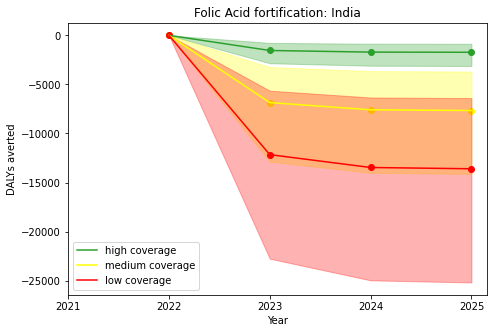

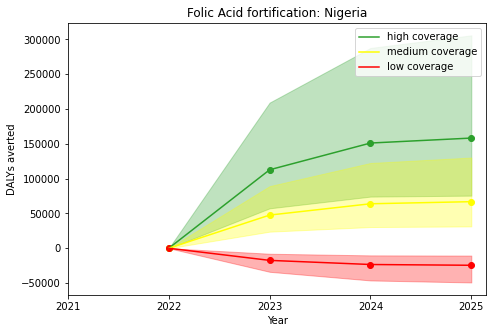

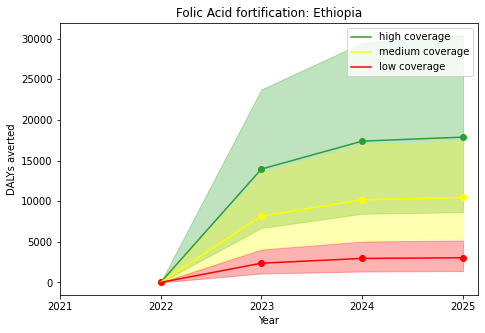

In [33]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


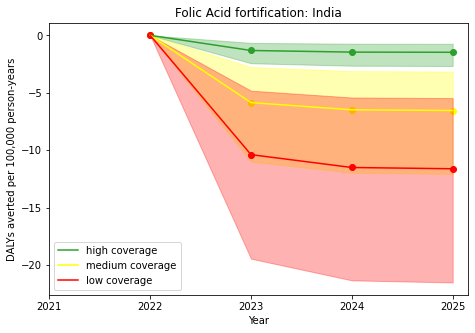

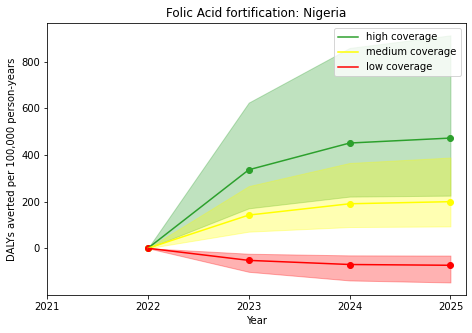

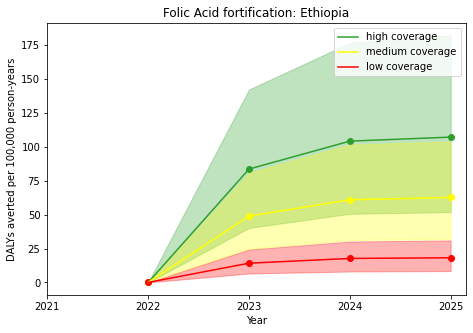

In [34]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {'full': 'tab:blue', 'high': 'tab:green', 'medium':'yellow', 'low': 'red'}
    
    for loc in [163,214,179]:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in ['high','medium','low']:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{level} coverage')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


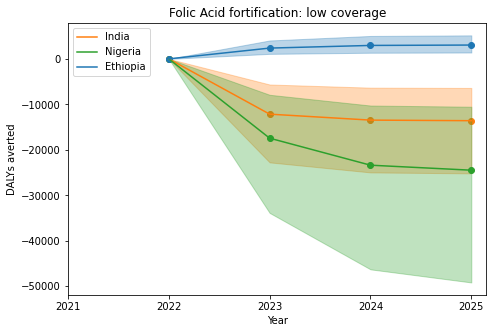

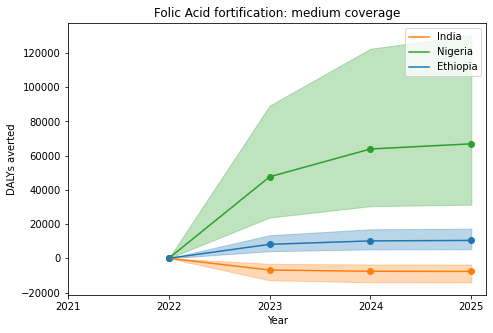

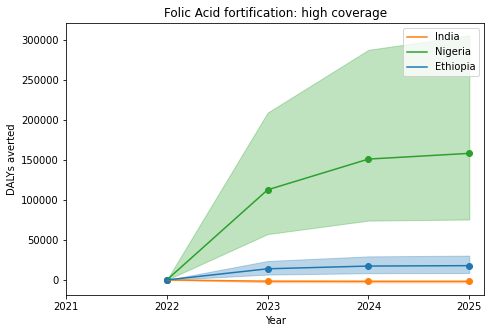

In [35]:
def plot_dalys_averted(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
plot_dalys_averted(save_path)


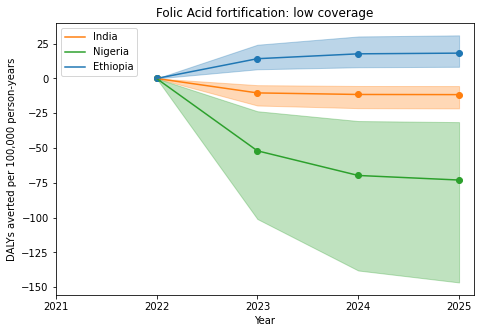

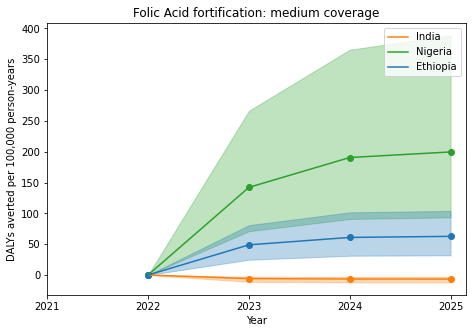

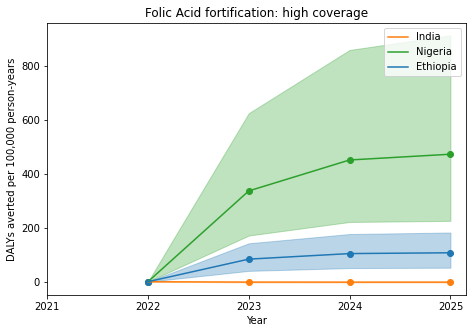

In [36]:
def plot_dalys_averted_rate(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {
        179:"Ethiopia",
        163:"India",
        214:"Nigeria",
        205:"Côte d'Ivoire",
        190:"Uganda",
        189:"United Republic of Tanzania"
    }
    colors = {179: 'tab:blue', 163: 'tab:orange', 214: 'tab:green', 205: 'yellow', 189:'purple'}

    for level in ['low', 'medium', 'high']:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for loc in [163,214,179]:
    #     for loc in [163]:

            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[loc])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[loc], label = location_names[loc])
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[loc])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification: {level} coverage')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)

    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
plot_dalys_averted_rate(save_path)